<a href="https://colab.research.google.com/github/SGeerthan/Lab07-Part2---IT22346568/blob/main/Question2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium torch matplotlib

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random, matplotlib.pyplot as plt
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
env = gym.make('CartPole-v1')
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n
print("States:", n_states, "Actions:", n_actions)

States: 4 Actions: 2


In [ ]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, action_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


In [ ]:
def select_action(model, state, epsilon):
    if random.random() < epsilon:
        return random.randrange(n_actions)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    q_values = model(state)
    return int(torch.argmax(q_values).item())


In [ ]:
def train_dqn(env, episodes=300, epsilon_start=0.1, lr=1e-3, gamma=0.99):
    model = DQN(n_states, n_actions).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    all_rewards = []

    for ep in range(episodes):
        state, info = env.reset() # gymnasium returns state and info
        total_reward = 0
        done = False

        while not done:
            action = select_action(model, state, epsilon_start)
            next_state, reward, terminated, truncated, info = env.step(action) # gymnasium returns terminated and truncated
            done = terminated or truncated

            # compute target
            s = torch.tensor(state, dtype=torch.float32, device=device)
            ns = torch.tensor(next_state, dtype=torch.float32, device=device)
            q_val = model(s).gather(0, torch.tensor(action, device=device))
            with torch.no_grad():
                target = reward + gamma * torch.max(model(ns)) * (1 - int(done))

            loss = F.mse_loss(q_val, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state
            total_reward += reward

        all_rewards.append(total_reward)
        if (ep+1) % 20 == 0:
            avg = np.mean(all_rewards[-20:])
            print(f"Episode {ep+1}/{episodes} | Avg reward (last 20): {avg:.2f}")

    return model, all_rewards

In [ ]:
epsilons = [0.1, 0.5, 0.9]
results = {}

for eps in epsilons:
    print(f"\nTraining DQN with epsilon={eps}")
    model, rewards = train_dqn(env, episodes=300, epsilon_start=eps)
    results[eps] = rewards



Training DQN with epsilon=0.1
Episode 20/300 | Avg reward (last 20): 9.55
Episode 40/300 | Avg reward (last 20): 13.30


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Episode 60/300 | Avg reward (last 20): 10.00
Episode 80/300 | Avg reward (last 20): 21.60
Episode 100/300 | Avg reward (last 20): 20.00
Episode 120/300 | Avg reward (last 20): 34.10
Episode 140/300 | Avg reward (last 20): 56.30
Episode 160/300 | Avg reward (last 20): 47.65
Episode 180/300 | Avg reward (last 20): 57.35
Episode 200/300 | Avg reward (last 20): 63.50
Episode 220/300 | Avg reward (last 20): 124.40
Episode 240/300 | Avg reward (last 20): 161.30
Episode 260/300 | Avg reward (last 20): 262.40
Episode 280/300 | Avg reward (last 20): 269.55
Episode 300/300 | Avg reward (last 20): 167.80

Training DQN with epsilon=0.5
Episode 20/300 | Avg reward (last 20): 13.70
Episode 40/300 | Avg reward (last 20): 20.50
Episode 60/300 | Avg reward (last 20): 19.30
Episode 80/300 | Avg reward (last 20): 28.90
Episode 100/300 | Avg reward (last 20): 44.10
Episode 120/300 | Avg reward (last 20): 59.30
Episode 140/300 | Avg reward (last 20): 58.60
Episode 160/300 | Avg reward (last 20): 82.40
Epis

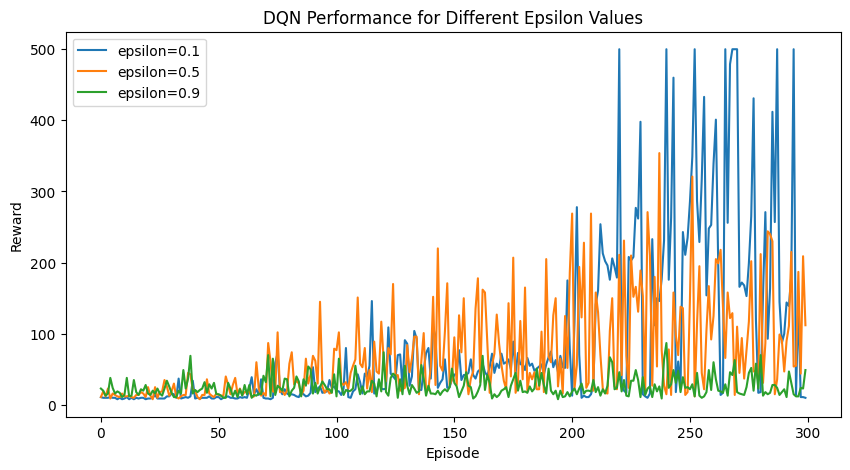

In [ ]:
plt.figure(figsize=(10,5))
for eps, rewards in results.items():
    plt.plot(rewards, label=f"epsilon={eps}")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN Performance for Different Epsilon Values")
plt.legend()
plt.show()
